In [24]:
from functions import pd, np, plt, load_data_foreign, load_data_pol, concat_and_select, calculate_returns
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable
# import numpy as np
# import pandas as pd
from IPython.display import display, clear_output
# import importlib
# importlib.reload(f)
import time

# D(tau) computations
* computed D matrices for tau 1-200 for both sp500 and GPW data
* computed null-hypothesis D for both sp500 and GPW data

In [55]:
# numpy version for calculating random matrices
def compute_D_matrix_fast(df, df_count):
    eta = df.values  # shape: (T, N)
    T, N = eta.shape

    # Generate random I ~ N(0, 1)
    I = np.random.normal(0, 1, T)  # tau = 0 ⇒ no shift needed
    I2_mean = np.mean(I ** 2)

    # Weight each row of eta by I (broadcast multiply)
    weighted_eta = eta * I[:, np.newaxis]  # shape: (T, N)

    numerator = (np.nan_to_num(weighted_eta).T @ np.nan_to_num(eta))  # shape: (N, N)

    # Final matrix
    D = numerator / df_count / I2_mean  # shape: (N, N)

    return D

In [63]:
def compute_D_matrix(df, index_series, tau, random_I=False, folder=None):
    eta_t = df.iloc[tau:]

    if random_I:
        n = len(df)
        I = np.random.normal(0, 1, n)
        I = pd.Series(I, index=df.index)
        tau=0
    else:
        I = index_series


    I2_mean = (I**2).mean()
    I_t_minus_tau = I.shift(tau).iloc[tau:].values  # shape: (T - τ, )

    # Weighted eta
    weighted_eta = eta_t * I_t_minus_tau[:, None]

    # Count of overlapping non-NaN values for normalization
    count = weighted_eta.notna().astype(int).T @ eta_t.notna().astype(int)

    # Numerator: dot product of weighted_eta and eta_t
    numerator = weighted_eta.fillna(0).T @ eta_t.fillna(0)

    # Final cross-correlation matrix
    D = numerator / count / I2_mean
    if folder:
        D.to_csv(folder+f'tau={tau}.csv')
    else:
        return pd.DataFrame(D, index=df.columns, columns=df.columns)

def read_D_matrix(dir, tau):
    D = pd.read_csv(f'C:/physics_masters/data/D_matrix/{dir}/tau={tau}.csv', index_col=0, header=0)
    return D

def read_eigvals(dir):
    D = pd.read_csv(f'C:/physics_masters/data/D_matrix/{dir}.csv', header=None)
    return D


def compute_random_eigenvals(df, N, name):
    all_eigvals = []
    
    count = df.notna().astype(int).T @ df.notna().astype(int)
    for _ in range(N):
        # random_m = compute_D_matrix(df, None, 0, True).values
        random_m = compute_D_matrix_fast(df, count)
        eigvals = np.linalg.eigvals(random_m)
        all_eigvals.append(eigvals.real)
        clear_output()
        print(f'\r{_}/{N}')  

    # Convert to DataFrame and save to CSV
    eigvals_df = pd.DataFrame(all_eigvals)
    eigvals_df.to_csv(f'C:/physics_masters/data/D_matrix/{name}.csv', index=False, header=False)

def compute_eigenvals(name):
    all_eigvals = []

    for t in range(1, 200):
        m = m = pd.read_csv(f'C:/physics_masters/data/D_matrix/{name}/tau={t}.csv', index_col=0, header=0)
        eigvals = np.linalg.eigvals(m)
        all_eigvals.append(eigvals.real)  

    # Convert to DataFrame and save to CSV
    eigvals_df = pd.DataFrame(all_eigvals)
    eigvals_df.to_csv(f'C:/physics_masters/data/D_matrix/{name}_eigenvals.csv', index_label=False, header=False)

def plot_D_matrix(D, tau, ax):
    ax.set_title(rf'D($\tau={tau}$)')
    return ax.imshow(D)


def marchenko_pastur_bounds(m, n):
    a, b =  (1-np.sqrt(n/m))**2, (1+np.sqrt(n/m))**2  #m, n inverse w.r.t. wikipedia definition
    return a, b
    

In [5]:
dataframes_sp500 = load_data_foreign('sp500', r"C:\\physics_masters\\data\\")
df_concat_sp500 = concat_and_select(dataframes_sp500, 0.99, cpi_file="CPI_US.csv")
df_concat_sp500, index_series_sp500 = calculate_returns(df_concat_sp500)

% of stocks remaining: 85.29%
% of dates remaining: 100.00%
Number of stocks: 429
Number of dates: 3645
% of nans: 0.03%


In [6]:
daily_omega = r"C:\\physics_masters\\data\\Bossa public market data\\pub\\daily\\omega\\"

dataframes_gpw = load_data_pol(daily_omega)
df_concat_gpw = concat_and_select(dataframes_gpw, 0.99, cpi_file='CPI_POL.csv') #0.99
df_concat_gpw, index_series_gpw = calculate_returns(df_concat_gpw)

% of stocks remaining: 12.50%
% of dates remaining: 99.89%
Number of stocks: 50
Number of dates: 3612
% of nans: 0.60%


In [5]:
datasets = {'sp500':df_concat_sp500, 'GPW':df_concat_gpw}

for name, df in datasets.items():
    for tau in range(1, 201):
        compute_D_matrix(df, df.mean(axis=1), tau, folder=f'C:/physics_masters/data/D_matrix/{name}/')
        clear_output()
        print(f'\r{tau}')

200


In [66]:
compute_random_eigenvals(df_concat_sp500, 500, f'sp500_random_I_eigenvals')

499/500


In [64]:
compute_random_eigenvals(df_concat_gpw, 500, f'gpw_random_I_eigenvals')

499/500


In [7]:
compute_eigenvals('sp500')
compute_eigenvals('GPW')

# SP500

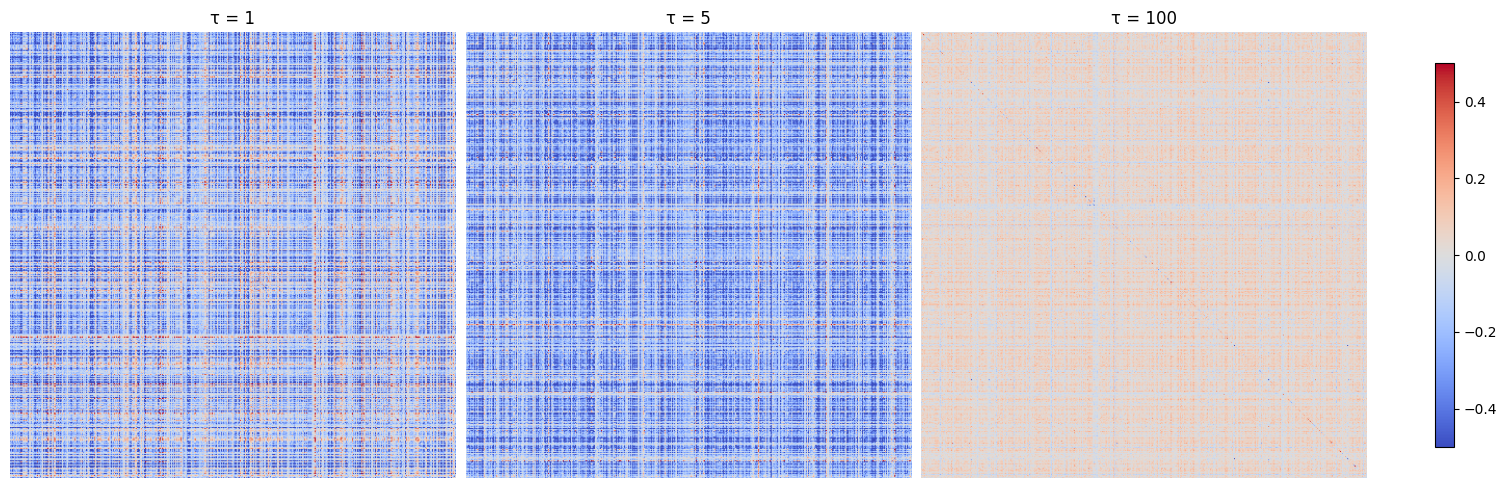

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Set your asymmetric range and center
vmin = -0.5
vmax = 0.5
vcenter = 0.0
cmap = plt.cm.coolwarm  # or seismic

# Define the custom normalization
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for colorbar

for t, ax in zip([1, 5, 100], axes):
    m = pd.read_csv(f'C:/physics_masters/data/D_matrix/sp500/tau={t}.csv', index_col=0, header=0)
    im = ax.imshow(m, cmap=cmap, norm=norm)
    ax.set_title(f"τ = {t}")
    ax.axis('off')

# Shared colorbar
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8)

plt.show()



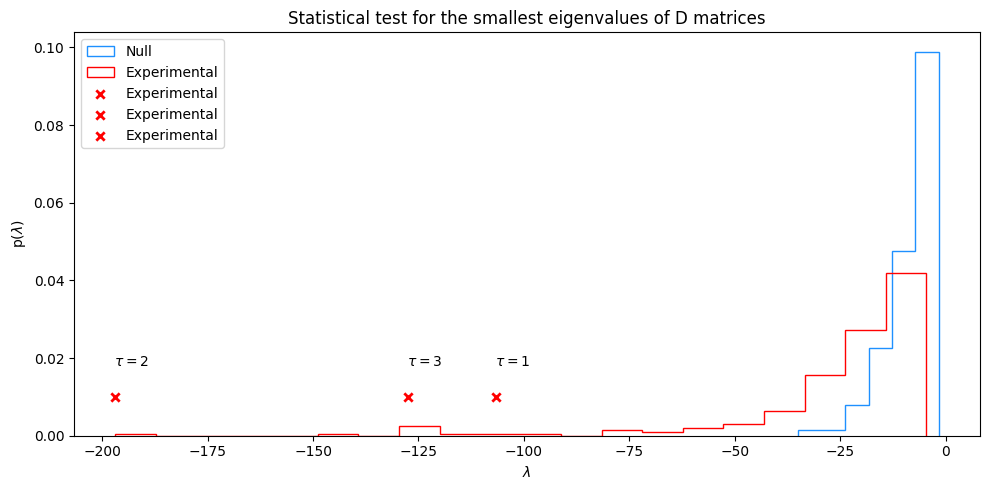

In [98]:
min_eigvals = read_eigvals('sp500_eigenvals').min(axis=1).values
eigvals_random = read_eigvals('sp500_random_I_eigenvals').min(axis=1).values
plt.figure(figsize=(10, 5))
plt.hist(eigvals_random, bins=6, density=True, histtype='step', lw=5,  edgecolor='dodgerblue', label='Null')
plt.hist(min_eigvals, bins=20, density=True, histtype='step',  edgecolor='red' , label='Experimental')

for t in [1, 2, 3]:
    plt.text(min_eigvals[t-1]-0.2, 0.018, rf'$\tau={t}$')
    plt.scatter(min_eigvals[t-1:t], [0.01], color='red', marker='x', lw=2, label='Experimental')

plt.xlabel(r'$\lambda$')
plt.ylabel(r'p($\lambda$)')
plt.title('Statistical test for the smallest eigenvalues of D matrices')
plt.legend()
plt.tight_layout()

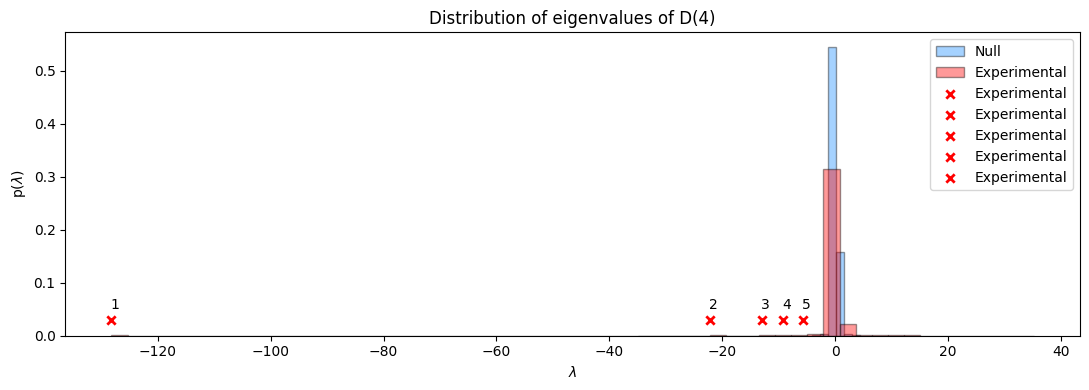

In [71]:
eigvals_random = read_eigvals('sp500_random_I_eigenvals').values.flatten()
eigvals_2 = read_eigvals('sp500_eigenvals').iloc[3].values

plt.figure(figsize=(11, 4))
plt.hist(eigvals_random, bins=50, density=True, alpha=0.4, color='dodgerblue', edgecolor='k', label='Null')
plt.hist(eigvals_2, bins=50, density=True, alpha=0.4, color='red', edgecolor='k', label='Experimental')

#plt.scatter(eigvals_2, np.full_like(eigvals_2, 0.01), color='red', marker='x', lw=2, label='Experimental')

for i, el in list(enumerate(np.sort(eigvals_2)))[:5]:
    plt.text(el-0.2, 0.05, rf'{1+i}')
    plt.scatter([el], [0.03], color='red', marker='x', lw=2, label='Experimental')


plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'p($\lambda$)')
plt.title('Distribution of eigenvalues of D(4)')
plt.tight_layout()


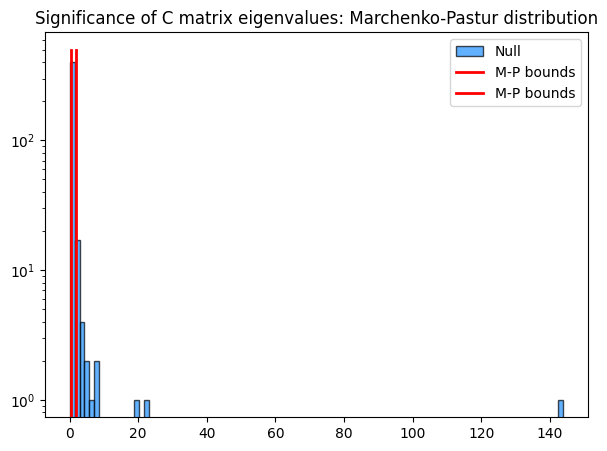

In [113]:
corr_m = df_concat_sp500.corr()
eigvals_corr = np.linalg.eigvals(corr_m)

plt.figure(figsize=(7, 5))
plt.hist(eigvals_corr, bins=100, density=False, alpha=0.7, color='dodgerblue', edgecolor='k', label='Null')

a, b = marchenko_pastur_bounds(*df_concat_sp500.shape)
plt.plot([a, a], [500, 0], color='red', lw=2, label='M-P bounds')
plt.plot([b, b], [500, 0], color='red', lw=2, label='M-P bounds')

plt.title('Significance of C matrix eigenvalues: Marchenko-Pastur distribution')
plt.legend()
plt.yscale('log')


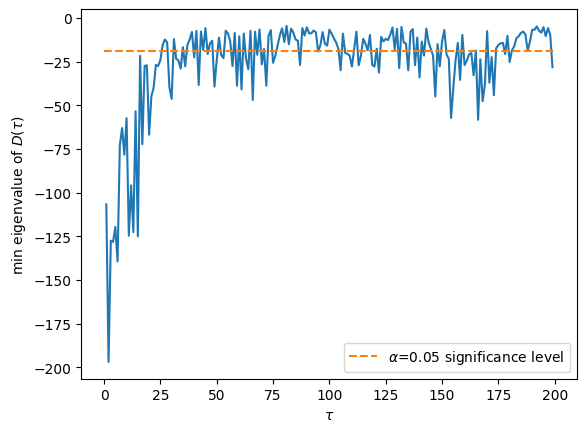

In [102]:
plt.plot(range(1, 200), min_eigvals)
plt.xlabel(r'$\tau$')
plt.ylabel(r'min eigenvalue of $D(\tau)$')
q = np.quantile(read_eigvals('sp500_random_I_eigenvals').min(axis=1).values, 0.05)
plt.plot([-.1, 200], [q, q], '--', label=r'$\alpha$=0.05 significance level')
plt.legend()

# GPW

important remark: N is small (possible problem)

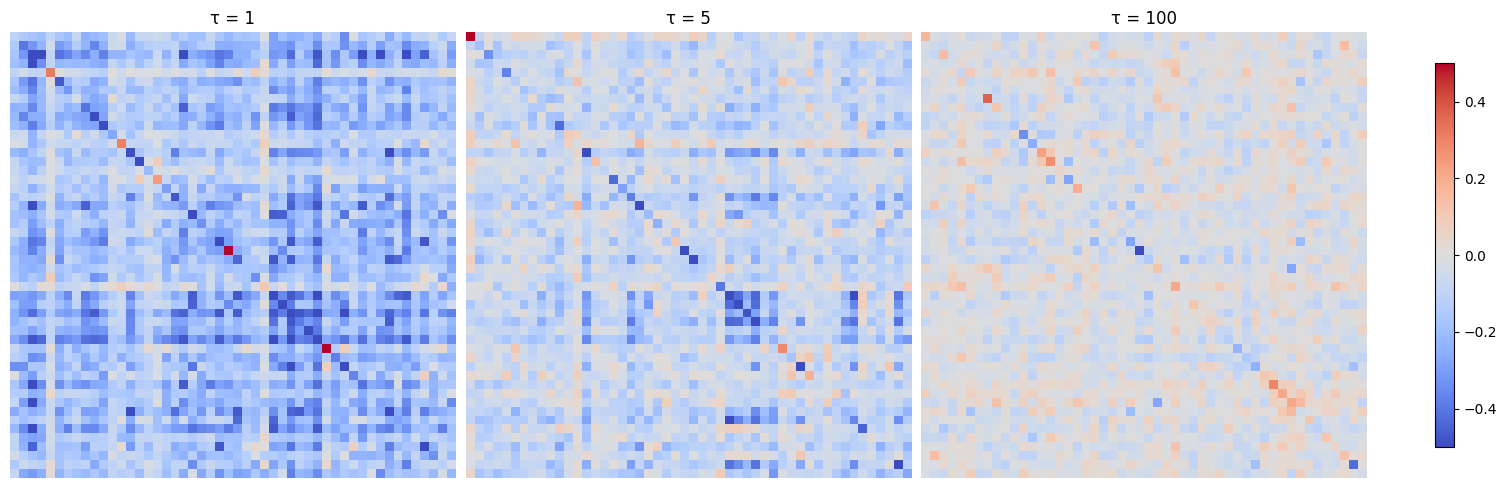

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Set your asymmetric range and center
vmin = -0.5
vmax = 0.5
vcenter = 0.0
cmap = plt.cm.coolwarm  # or seismic

# Define the custom normalization
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for colorbar

for t, ax in zip([1, 5, 100], axes):
    m = pd.read_csv(f'C:/physics_masters/data/D_matrix/GPW/tau={t}.csv', index_col=0, header=0)
    im = ax.imshow(m, cmap=cmap, norm=norm)
    ax.set_title(f"τ = {t}")
    ax.axis('off')

# Shared colorbar
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8)

plt.show()

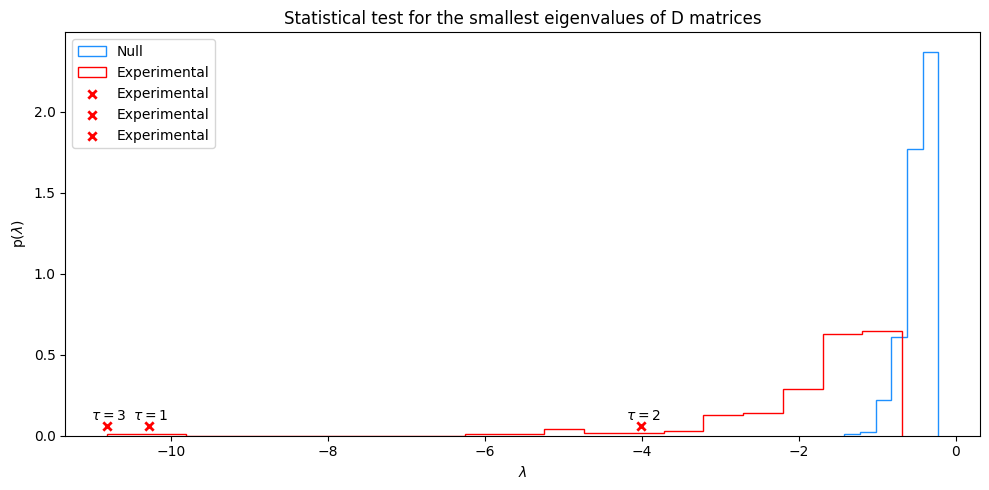

In [127]:
min_eigvals = read_eigvals('GPW_eigenvals').min(axis=1).values
eigvals_random = read_eigvals('GPW_random_I_eigenvals').min(axis=1).values
plt.figure(figsize=(10, 5))
plt.hist(eigvals_random, bins=6, density=True, histtype='step',  edgecolor='dodgerblue', label='Null')
plt.hist(min_eigvals, bins=20, density=True, histtype='step',  edgecolor='red', label='Experimental')

for t in [1, 2, 3]:
    plt.text(min_eigvals[t-1]-0.2, 0.1, rf'$\tau={t}$')
    plt.scatter(min_eigvals[t-1:t], [0.06], color='red', marker='x', lw=2, label='Experimental')

plt.xlabel(r'$\lambda$')
plt.ylabel(r'p($\lambda$)')
plt.title('Statistical test for the smallest eigenvalues of D matrices')
plt.legend()
plt.tight_layout()

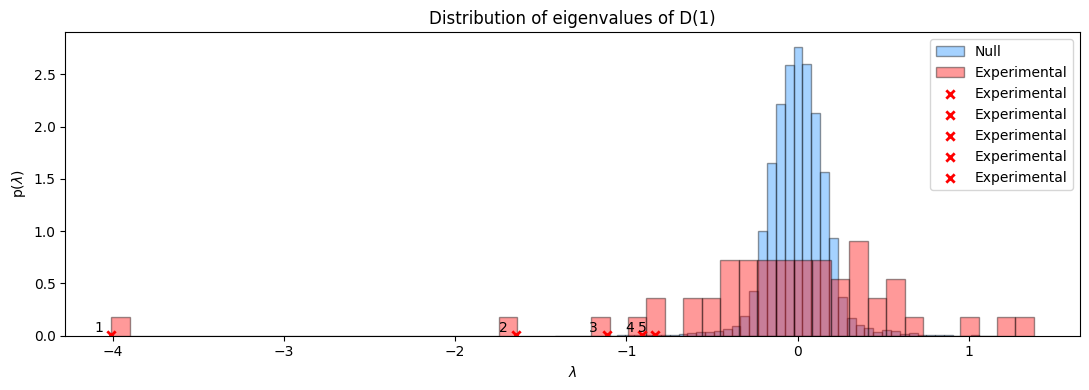

In [128]:
tau = 1

eigvals_random = read_eigvals('GPW_random_I_eigenvals').values.flatten()
eigvals_2 = read_eigvals('GPW_eigenvals').iloc[tau].values

plt.figure(figsize=(11, 4))
plt.hist(eigvals_random, bins=50, density=True, alpha=0.4, color='dodgerblue', edgecolor='k', label='Null')
plt.hist(eigvals_2, bins=50, density=True, alpha=0.4, color='red', edgecolor='k', label='Experimental')

for i, el in list(enumerate(np.sort(eigvals_2)))[:5]:
    plt.text(el-0.1, 0.04, rf'{1+i}')
    plt.scatter([el], [0.01], color='red', marker='x', lw=2, label='Experimental')


plt.legend()
plt.xlabel(r'$\lambda$')
plt.ylabel(r'p($\lambda$)')
plt.title(f'Distribution of eigenvalues of D({tau})')
plt.tight_layout()

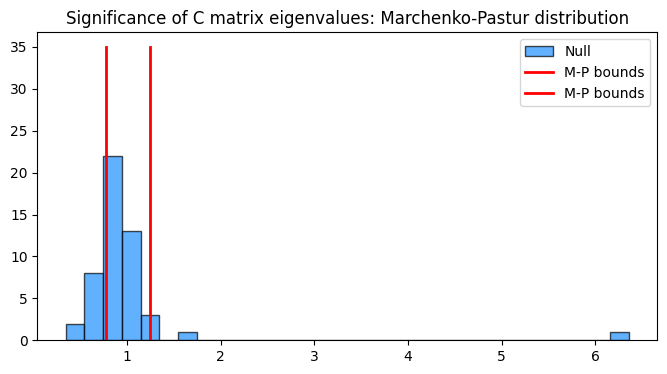

In [129]:
corr_m = df_concat_gpw.corr()
eigvals_corr = np.linalg.eigvals(corr_m)

plt.figure(figsize=(8, 4))
plt.hist(eigvals_corr, bins=30, density=False, alpha=0.7, color='dodgerblue', edgecolor='k', label='Null')

a, b = marchenko_pastur_bounds(*df_concat_gpw.shape)
plt.plot([a, a], [35, 0], color='red', lw=2, label='M-P bounds')
plt.plot([b, b], [35, 0], color='red', lw=2, label='M-P bounds')

plt.title('Significance of C matrix eigenvalues: Marchenko-Pastur distribution')
plt.legend()


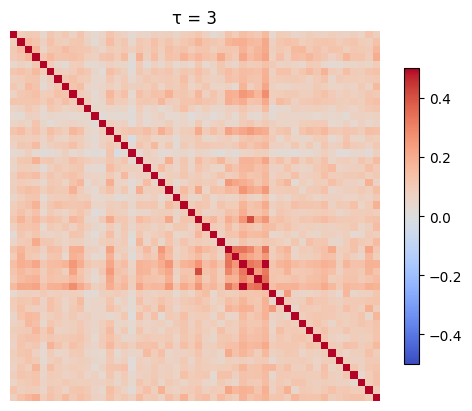

In [130]:
vmin = -0.5
vmax = 0.5
vcenter = 0.0
cmap = plt.cm.coolwarm  # or seismic

# Define the custom normalization
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for colorbar

fig, ax = plt.subplots()
im = ax.imshow(corr_m, cmap=cmap, norm=norm)
ax.set_title(f"τ = {t}")
ax.axis('off')
cb = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8)
plt.show()

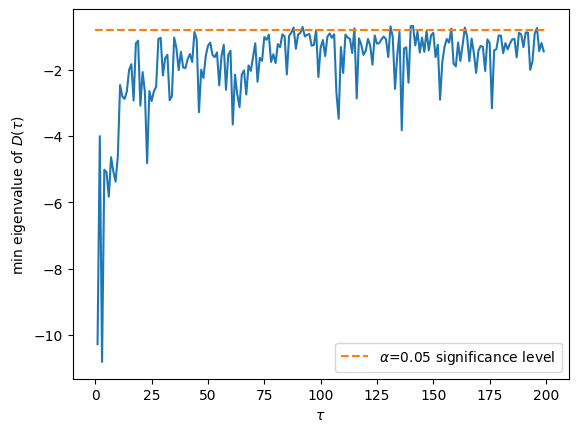

In [131]:
plt.plot(range(1, 200), min_eigvals)
plt.xlabel(r'$\tau$')
plt.ylabel(r'min eigenvalue of $D(\tau)$')
q = np.quantile(read_eigvals('gpw_random_I_eigenvals').min(axis=1).values, 0.05)
plt.plot([-.1, 200], [q, q], '--', label=r'$\alpha$=0.05 significance level')
plt.legend()